In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import xarray as xr
import tqdm
import utils as utils
import cartopy.crs as ccrs
# import scienceplots
# plt.style.use('science')

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_spatial_GP as plaingp
import src.evaluation.visualisation as vis

<IPython.core.display.Javascript object>

In [3]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp370', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp245']}}
test_data = plaingp.make_data(test_cfg)

gpmodel = plaingp.make_model(train_cfg, train_data)
state_dict = torch.load('../sandbox/output/dev/spatial-gp/state_dict.pt')
gpmodel.load_state_dict(state_dict)

torch.Size([13824])


<All keys matched successfully>

In [4]:
test_scenarios = test_data.scenarios
Xtest = test_scenarios.glob_inputs[:, 1:]
Xtest = (Xtest - gpmodel.mu) / gpmodel.sigma
test_tas = test_scenarios.tas
gpmodel = gpmodel.eval()

In [5]:
with torch.no_grad():
    gp_test_posterior = gpmodel.posterior(Xtest)
    mean = gpmodel.sigma_targets.view(-1, 1) * gp_test_posterior.mean + gpmodel.mu_targets.view(-1, 1)
    variance = gpmodel.sigma_targets.pow(2).view(-1, 1) * gp_test_posterior.variance
    noisy_variance = variance + gpmodel.likelihood.noise
    gp_test_posterior = gp_test_posterior.__class__(mean, variance)
    noisy_gp_test_posterior = gp_test_posterior.__class__(mean, noisy_variance)

In [6]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)
gp_posterior_mean = noisy_gp_test_posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
gp_posterior_stddev = noisy_gp_test_posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)

def encapsulate_as_xarray(data, scenario):
    field = xr.DataArray(data=data.cpu(),
                         dims=['time', 'lat', 'lon'],
                         coords=dict(time=scenario.timesteps.cpu(),
                                     lat=scenario.lat.cpu(),
                                     lon=scenario.lon.cpu()))
    return field

encapsulate = lambda data: encapsulate_as_xarray(data, test_scenarios[0])
xr_posterior_mean = encapsulate(gp_posterior_mean)
xr_posterior_stddev = encapsulate(gp_posterior_stddev)
xr_groundtruth = encapsulate(test_tas)

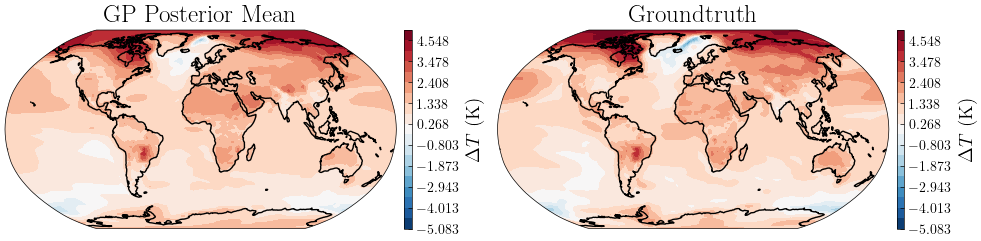

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': ccrs.Robinson()})

idx = 20

vmax = max(gp_posterior_mean[idx].max(), test_tas[idx].max())

vis.plot_contourf_on_ax(xr_posterior_mean.isel(time=idx), fig, ax[0], colorbar=True, vmax=vmax)
vis.plot_contourf_on_ax(xr_groundtruth.isel(time=idx), fig, ax[1], colorbar=True, vmax=vmax)

ax[0].set_title("GP Posterior Mean", fontsize=18)
ax[1].set_title("Groundtruth", fontsize=18)

plt.tight_layout()
plt.show()